# Generative Adversarial Networks

Применение adversarial loss (более общей идеи, лежащей в основе GANов) позволило решить задачи, которые казались невозможными:

* [Машинный перевод без параллельных данных](https://arxiv.org/pdf/1710.11041.pdf)
* [Циклоганы: перевод изображений в другой домен](https://arxiv.org/abs/1703.10593)
* Колоризация и [Super Resolution](https://arxiv.org/abs/1807.02758)
* [Генерация и морфинг произвольных данных](https://arxiv.org/pdf/1809.11096.pdf) ([тут](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=HuCO9tv3IKT2) можно поиграться с генерацией бургеров)
* Применения в борьбе с adversarial атаками

Вот постоянно пополняющийся список приложений GANов: https://github.com/nashory/gans-awesome-applications

Сама [статья](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) Яна Гудфеллоу про GANы вышла в конце 2014 года и была процитирована 7687 раз за 4 года.


<img width='500px' src='https://cdn-images-1.medium.com/max/800/1*eWURQXT41pwHvDg1xDiEmw.png'>

Теперь немного формальных определений:

* Пусть $z$ — это вектор из латентного пространства, насэмпленный из нормального распределения.
* $G(z)$ обозначает функцию генератора, которая отображает латентный вектор в пространство данных. Цель $G$ — оценить истинное распределение данных $p_d$, чтобы сэмплировать данные из оцененного распределения $p_g$.
* $D(G(z))$ это вероятность (число от 0 до 1), что выход генератора $G$ является реальным изображением.

$D$ и $G$ играют в минимаксную игру, в которой $D$ старается максимизировать вероятность, что он правильно классифицирует реальные и сгенерированные сэмплы, а $G$ старается минимизировать эту вероятность:

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]$$

[Выясняется](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), что решение в этой минимаксной игре достигается при $p_g = p_d$ (и дискриминатор в этом случае может угадывать случайно). В реальности модели не всегда могут сойтись к этой точке.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional GAN) называют GAN, который явно использует свёртки и транспонированные свёртки в дискриминаторе и генераторе соответственно. Откройте статью -- мы будем идти очень близко с авторами.

## Датасет
Всем надоели цифры, поэтому обучаться мы будем на датасете CelebA ([Large-scale CelebFaces Attributes](Large-scale CelebFaces Attributes)). В датасете на каждую фотку есть её аттрибуты, но мы их пока использовать не будем.

<img width='500px' src='http://mmlab.ie.cuhk.edu.hk/projects/celeba/overview.png'>

Автор, когда готовил эту тетрадку, долго думал, как загрузить датасет, чтобы всем было удобно. Это оказалось трудно, потому что прямых ссылок на него нигде нет, и, соответственно, просто сделать `!wget ...` нельзя. По удачному стечению обстоятельств, неделю назад кто-то [добавил](https://github.com/pytorch/vision/blob/master/torchvision/datasets/celeba.py) скрипты для загрузки этого датасета в сам `torchvision`, но в `pip` новая версия за такой срок ещё не успела появиться, поэтому мы обновимся напрямую из репозитория на гитхабе:

In [1]:
# модель будет обучаться долго - рекомендую сохранять промежуточные версии. В колабе это можно делать примерно так
from google.colab import drive
drive.mount('/content/drive')
#теперь для сохранения файлов вам доступна директория /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets

In [3]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64

In [4]:
!pip install hub

     |████████████████████████████████| 355 kB 4.8 MB/s 
     |████████████████████████████████| 6.2 MB 25.6 MB/s 
     |████████████████████████████████| 81 kB 11.1 MB/s 
     |████████████████████████████████| 132 kB 63.6 MB/s 
     |████████████████████████████████| 8.7 MB 60.7 MB/s 
     |████████████████████████████████| 79 kB 10.5 MB/s 
     |████████████████████████████████| 138 kB 75.4 MB/s 
     |████████████████████████████████| 65 kB 4.5 MB/s 
     |████████████████████████████████| 127 kB 71.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import hub
ds = hub.load("hub://activeloop/celeb-a-train")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/celeb-a-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train


In [5]:
ds.visualize()

 * Serving Flask app "dataset_visualizer" (lazy loading)
 * Environment: production


   Use a production WSGI server instead.
 * Debug mode: off


In [6]:
ds.tensors.keys()

dict_keys(['images', 'boxes', 'keypoints', 'clock_shadow', 'arched_eyebrows', 'attractive', 'bags_under_eyes', 'bald', 'bangs', 'big_lips', 'big_nose', 'black_hair', 'blond_hair', 'blurry', 'brown_hair', 'bushy_eyebrows', 'chubby', 'double_chin', 'eyeglasses', 'goatee', 'gray_hair', 'heavy_makeup', 'high_cheekbones', 'male', 'mouth_slightly_open', 'mustache', 'narrow_eyes', 'no_beard', 'oval_face', 'pale_skin', 'pointy_nose', 'receding_hairline', 'rosy_cheeks', 'sideburns', 'smiling', 'straight_hair', 'wavy_hair', 'wearing_earrings', 'wearing_hat', 'wearing_lipstick', 'wearing_necklace', 'wearing_necktie', 'young'])

In [7]:
len(ds.images[0].numpy()), len(ds.images[0].numpy()[0])

(295, 285)

In [8]:
transform=transforms.Compose([
    transforms.ToPILImage(), ###
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = ds.pytorch(num_workers=0, batch_size=batch_size, transform={
                        'images': transform}, shuffle=False)

In [9]:
dataloader

In [10]:
for data in dataloader:
  print(data['images'].numpy().shape)
  break

(64, 3, 64, 64)


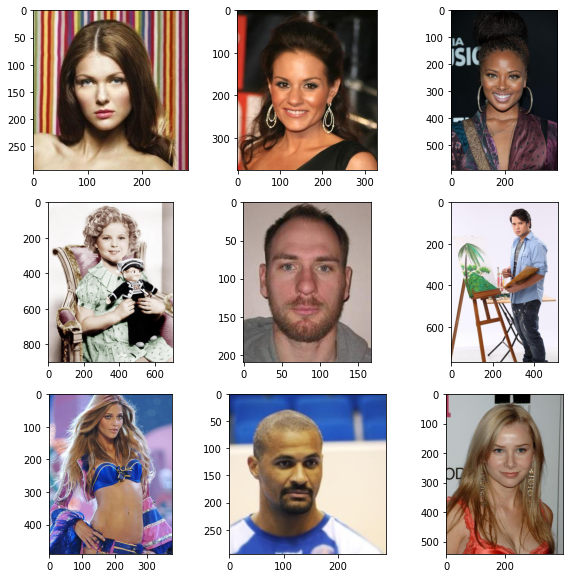

In [11]:
import matplotlib.pyplot as plt

imgs_num = 10

fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3
for i in range(1, columns * rows +1):
    img = ds.images[i - 1].numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Модель

Генератор $G$ преобразует латентный вектор $z$ в пространство данных (в нашем случае -- картинки 3x64x64). В статье используют последовательность блоков из транспонированных свёрток, BatchNorm-ов и ReLU. На выходе каждое значение лежит в [-1, 1] (мы делаем TanH), в соответствии с нормализацией, которую мы сделали раньше.

<img width='600px' src='https://pytorch.org/tutorials/_images/dcgan_generator.png'>

In [12]:
device = torch.device('cuda:0')

In [13]:
num_channels = 3
latent_size = 150
base_size = 64

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(latent_size, base_size * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),
    
    # (base_size*8) x 4 x 4
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),
    
    # (base_size*4) x 8 x 8
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),
    
    # (base_size*2) x 16 x 16
    nn.ConvTranspose2d(base_size * 2, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.ReLU(True),
    
    # (base_size) x 32 x 32
    nn.ConvTranspose2d(base_size, num_channels, 4, 2, 1, bias=False),
    nn.Tanh()
    # (num_channels) x 64 x 64
).to(device)

In [14]:
z = torch.randn(batch_size, latent_size, 1, 1).to(device)
G(z).shape

torch.Size([64, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


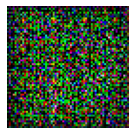

In [15]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 64, 64).transpose(0, 1).transpose(1, 2).numpy()

img_pred = to_numpy_image(G(z)[0])
plt.figure(figsize=(10,10))

plt.subplot(141)
plt.axis('off')
plt.imshow(img_pred.reshape((64, 64, 3)))

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d... Параметры сверток можно поставить в обратную сторону.

In [17]:
D = nn.Sequential(
    nn.Conv2d(3, base_size, 4, 2, padding=1, bias=False),
    nn.ReLU(True),

    nn.Conv2d(base_size, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),

    nn.Conv2d(base_size * 2, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),

    nn.Conv2d(base_size * 4, base_size * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),

    nn.Conv2d(base_size * 8, 1, 4, 1, 0, bias=False),

    nn.Sigmoid()
).to(device)

In [18]:
z = torch.randn(batch_size, num_channels, image_size, image_size).to(device)
z.shape

torch.Size([64, 3, 64, 64])

In [19]:
torch.cuda.empty_cache()

In [20]:
D(z).shape, D(z)[0:3]

(torch.Size([64, 1, 1, 1]), tensor([[[[0.5558]]],
 
 
         [[[0.5500]]],
 
 
         [[[0.7683]]]], device='cuda:0', grad_fn=<SliceBackward0>))

В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет применяет функцию ко всем своим подмодулям
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU(inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

In [22]:
# torch.save(D.state_dict(), '/content/drive/MyDrive/D.pt')
# torch.save(G.state_dict(), '/content/drive/MyDrive/G.pt')

# если мы предварительно сохраняли модели и хотим запустить их, то это вот так
D.load_state_dict(torch.load('/content/drive/MyDrive/D.pt')) # можно и другую директорию, но вот это прямо внутри вашего гугл диска
G.load_state_dict(torch.load('/content/drive/MyDrive/G.pt'))

<All keys matched successfully>

In [ ]:
torch.autograd.set_detect_anomaly(True)

0/5, 0.0
  G loss: 6.75668478012085
  D loss: 0.022797444835305214

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


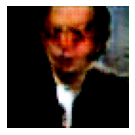

KeyboardInterrupt: ignored

In [27]:
num_epochs = 5
learning_rate = 2e-4

img_list = []
G_losses = []
D_losses = []
iters = 0

optim_G = torch.optim.AdamW(G.parameters(), lr=learning_rate) # оптимизатор параметров дискриминатора
optim_D = torch.optim.AdamW(D.parameters(), lr=learning_rate) # оптимизатор параметров генератора
criterion = nn.BCELoss()
  
for epoch in range(num_epochs):
    for data in dataloader:
        z = torch.randn(batch_size, latent_size, 1, 1).to(device)

        # Распакуйте данные на нужный девайс
        data = data['images']
        data = data.to(device)

        # Обучим D: max log(D(x)) + log(1 - D(G(z)))
        optim_D.zero_grad()
        
        #    Прогоните через сеть
        real_pics_estimations = D(data)
        fakes = G(z)
        fake_pics_estimations = D(fakes)

        y_size = real_pics_estimations.shape[0]
        y = torch.ones(y_size).to(device)

        yf_size = fake_pics_estimations.shape[0]
        yf = torch.zeros(yf_size).to(device)
        
        loss_D1 = criterion(real_pics_estimations.view((y_size)), y)
        loss_D2 = criterion(fake_pics_estimations.view((yf_size)), yf)
        loss_D = loss_D1 + loss_D2
        loss_D.backward()
        optim_D.step()

        D_losses.append(loss_D.mean().item())

        # 2. Обучим G: max log(D(G(z)))

        optim_G.zero_grad()
        
        # Тут проще:
        #    Получим вектор неправильных ответов -- вектор единиц (мы ведь хотим, чтобы D считал их неправильными)
        #    Прогоним ранее сгенерированные картинки через D
        #    Посчитаем лосc, сделаем .backward()
        # fake_pics_estimations = D(G(z))
        fakes = G(z)
        fake_pics_estimations = D(fakes)
        y_size = fake_pics_estimations.shape[0]
        y = torch.ones(y_size).to(device)
        loss_G = criterion(fake_pics_estimations.view((y_size)), y)
        loss_G.backward()
        G_losses.append(loss_G.item())
        
        optim_G.step()

        D.train()
        G.train()

        # Раз в сколько-то итераций логгируем лосс
        if iters % 10 == 0:
            # Выведем информацию о том, как наша сеть справляется
            print(f'{epoch}/{num_epochs}, {iters/len(dataloader)}')
            print(f'  G loss: {G_losses[-1]}')
            print(f'  D loss: {D_losses[-1]}')
            print()

        if iters % 50 == 0:
            # вы на этом батче уже генерировали какие-то картинки: просто добавьте их в список
            img_list.append(fakes)
            # а вот тут сохраняем
            torch.save(D.state_dict(), '/content/drive/MyDrive/D.pt')
            torch.save(G.state_dict(), '/content/drive/MyDrive/G.pt')
        if iters % 500 == 0:
            img_pred = to_numpy_image(img_list[-1][-1])
            plt.figure(figsize=(10,10))

            plt.subplot(141)
            plt.axis('off')
            plt.imshow(img_pred.reshape((64, 64, 3)))
            plt.show()
        iters += 1

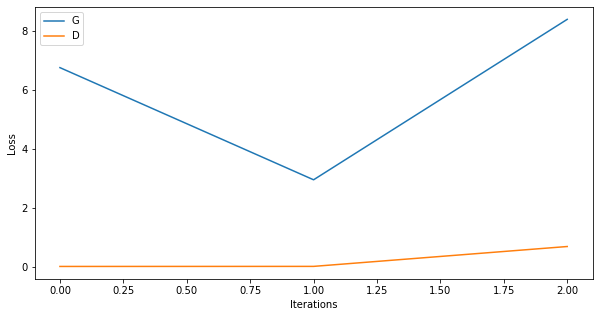

In [28]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


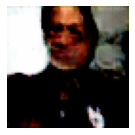

In [33]:
img_pred = to_numpy_image(G(torch.randn(batch_size, latent_size, 1, 1).to(device))[0])
plt.figure(figsize=(10,10))

plt.subplot(141)
plt.axis('off')
plt.imshow(img_pred.reshape((64, 64, 3)))

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.